In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import Imagenette
from torchsummary import summary
from torchvision.models import resnet50,ResNet50_Weights

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
image_size = 227
stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
    ])


train_data_path = "/content/drive/MyDrive/cat_dog/training_set"
dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data_path = "/content/drive/MyDrive/cat_dog/test_set"
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

In [78]:
train_loader = DataLoader(dataset, batch_size=500, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=500, shuffle=True)

In [79]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [80]:
for params in model.parameters():
  params.requires_grad_(False)

In [81]:
model.fc=nn.Sequential(nn.Linear(in_features=2048,out_features=1),nn.Sigmoid())

In [82]:
criterion=nn.BCELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=0.0005,momentum=0.9)

In [83]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [84]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
train_loss=[]
val_loss=[]
prev_val=10
model=model.to(device)
for i in range(50):
  model.train()
  train_batch_loss=[]
  for x_data,y_data in train_loader:
    x_data,y_data=x_data.to(device),y_data.unsqueeze(1).float().to(device)
    logits=model(x_data)
    loss=criterion(logits,y_data)
    train_batch_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  with torch.no_grad():
    model.eval()
    val_batch_loss=[]
    for x_data,y_data in test_loader:
      x_data,y_data=x_data.to(device),y_data.unsqueeze(1).float().to(device)
      logits=model(x_data)
      valloss=criterion(logits,y_data)
      val_batch_loss.append(valloss.item())


  train_loss.append(sum(train_batch_loss)/len(train_batch_loss))
  val_loss.append(sum(val_batch_loss)/len(val_batch_loss))

  if valloss.item() < prev_val:
    prev_val = valloss.item()
    torch.save(model.state_dict(), '/content/drive/MyDrive/model/resnet.pth')

  if (i%2==0):
    print(f"Epoch:{i}\tTrain Loss={loss.item()}\tVal Loss={valloss.item()}")

Epoch:0	Train Loss=0.19018012285232544	Val Loss=0.1905221939086914
Epoch:2	Train Loss=0.15882784128189087	Val Loss=0.0455750972032547
Epoch:4	Train Loss=0.3945455551147461	Val Loss=0.05853813886642456
Epoch:6	Train Loss=0.15846769511699677	Val Loss=0.08843877166509628
Epoch:8	Train Loss=0.276507705450058	Val Loss=0.05188794806599617
Epoch:10	Train Loss=0.018577270209789276	Val Loss=0.10782288759946823
Epoch:12	Train Loss=0.012796121649444103	Val Loss=0.026995273306965828
Epoch:14	Train Loss=0.053079940378665924	Val Loss=0.10673655569553375
Epoch:16	Train Loss=0.08470415323972702	Val Loss=0.033360887318849564
Epoch:18	Train Loss=0.03305421397089958	Val Loss=0.007478795945644379
Epoch:20	Train Loss=0.01374253910034895	Val Loss=0.10986542701721191
Epoch:22	Train Loss=0.22945530712604523	Val Loss=0.07910360395908356
Epoch:24	Train Loss=0.014291766099631786	Val Loss=0.07681865245103836
Epoch:26	Train Loss=0.019305549561977386	Val Loss=0.07587864249944687
Epoch:28	Train Loss=0.31765368580818

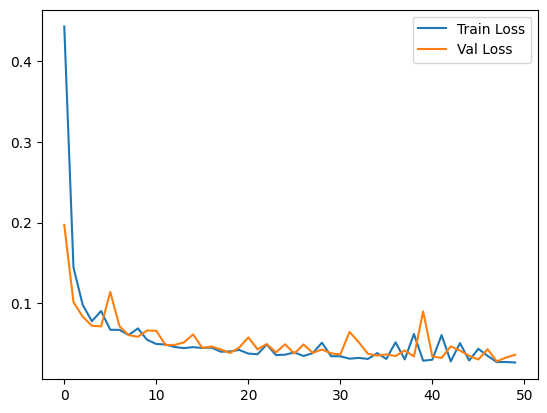

In [115]:
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Val Loss")
plt.legend()
plt.show()

In [88]:
state_dict=torch.load('/content/drive/MyDrive/model/resnet.pth',weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
logits.shape

torch.Size([500, 1])

In [114]:
correct = 0
total = 0

with torch.no_grad():
    model.to(device)
    model.eval()

    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.unsqueeze(1).to(device)

        logits = model(x_test)


        pred = torch.tensor([1 if i.item() > 0.5 else 0 for i in logits]).unsqueeze(1).to(device)


        correct += (pred == y_test).sum()
        total += y_test.shape[0]

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 99.21%
